In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training.train_state import TrainState
from clu import metrics
import flax
import optax

In [3]:
import os

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [5]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# meshes = []
# for idx in range(1,22):
#     mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [6]:
fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'
fork_scale = knife_scale = 1.0
box_scale = 1e-3
table_scale = 1e-6
mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
scales = (fork_scale, knife_scale, box_scale, table_scale)
for mesh_path, scale in zip(mesh_paths, scales):
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

Centering mesh with translation [-0.02541  -0.022295  0.007042]
Centering mesh with translation [-0.019428  -0.0274155  0.003918 ]


In [7]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [8]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

In [9]:
SHIFT_MIN = -0.2
SHIFT_SCALE = 0.4
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.1, 0.0])

In [10]:
def fork_spoon_from_known_params(is_fork, shift):
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift*jnp.cos(jnp.pi/12), -0.05 + shift*jnp.sin(jnp.pi/12), 10*jnp.pi/12]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return (is_fork, rendered)

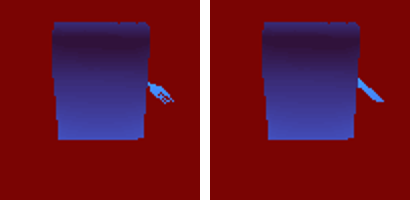

In [11]:
ss = -0.1
b.viz.hstack_images([b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(True, ss)[1][...,2]), 2),
                     b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(False, ss)[1][...,2]), 2)])

In [12]:
def fork_spoon_generator(key):
    is_fork_key, shift_key = jax.random.split(key, 2)
    is_fork = jax.random.bernoulli(is_fork_key)
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(shift_key)

    return fork_spoon_from_known_params(is_fork, shift)

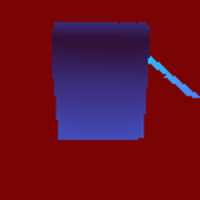

In [13]:
b.viz.scale_image(b.get_depth_image(fork_spoon_generator(jax.random.PRNGKey(0))[1][...,2]), 2)

In [14]:
make_onehot = lambda b: jax.lax.cond(b, lambda: jnp.array([0.0, 1.0]), lambda: jnp.array([1.0, 0.0]))

In [15]:
@jax.jit
def make_batch(batch_keys):
    batch_size = batch_keys.shape[0]
    def loop_body(i, imgs_labels):
        imgs, labels = imgs_labels
        label, img = fork_spoon_generator(batch_keys[i])
        return (imgs.at[i, :, :, 0].set(img[:, :, 2]),
                labels.at[i, :].set(make_onehot(label)))
    return jax.lax.fori_loop(0, batch_keys.shape[0],
                             loop_body,
                             (jnp.zeros((batch_size, 100, 100,1)), jnp.zeros((batch_size, 2))))

In [16]:
N_TRAIN = 30000
N_TEST = 2000

In [17]:
train_data = make_batch(jax.random.split(jax.random.PRNGKey(0), N_TRAIN))

In [18]:
jnp.savez('train_data.npz', *train_data)

In [19]:
test_data = make_batch(jax.random.split(jax.random.PRNGKey(2718), N_TEST))

In [20]:
jnp.savez('test_data.npz', *test_data)